In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy.stats as stats

In [103]:
ID = 'HD97334'
samples = pd.read_csv(f'examples_samples_{ID}.csv')
samples.head()

,numax,dnu,teff,bp_rp,eps_p,d02,alpha_p,env_height,env_width,mode_width,H1_nu,H1_exp,H_power,H2_nu,H2_exp,d01
0,3.502947,2.145991,3.782363,0.733920,1.268195,0.988296,-2.865301,0.247585,2.529392,0.305118,3.412542,3.311284,2.771001,2.864738,3.140043,1.816972
1,3.505282,2.151615,3.772342,0.781711,1.370185,0.990591,-3.180296,0.141483,2.446516,0.178075,3.369116,3.421372,2.770047,2.848603,2.910730,1.820789
2,3.534471,2.172875,3.780857,0.742189,1.297410,1.009332,-2.978240,0.133804,2.547691,0.277381,3.397999,3.147192,2.755168,2.891942,3.772379,1.840554
3,3.504113,2.146539,3.773673,0.770022,1.329127,0.988937,-2.710160,0.494685,2.548263,0.263318,3.412874,3.127900,2.795474,2.861491,3.218952,1.817288
4,3.514921,2.155243,3.780761,0.742281,1.285530,0.996144,-2.816687,0.321067,2.572994,0.324536,3.480654,4.066939,2.754353,2.890779,3.333079,1.827499


In [104]:
class model():
    def __init__(self, nu):
        '''  The hard coded value of 20 is a massive fudge ... look at this! '''
        self.nu = nu
        self.N_p = np.arange(10, 30, 1)
        self.vis={'V20': 0.71, 'V10': 1.5}
        self.rv_factor = 20.0
    
    def model_(self, theta_u):
        
        
        # l=2,0
        modes, _ = self.addModes(**theta_u)
        
        # Background
        bkg = self.background(theta_u)
         
        return (modes * bkg) + bkg / self.rv_factor
    
    def addModes(self, d02, d01, mode_width, **kwargs):
         
        modes = np.zeros_like(self.nu)
        
        nu0_p = self.asymptotic_nu_p(**kwargs)

        Hs0 = self.envelope(nu0_p, **kwargs)

        for i, n in enumerate(self.N_p):

            # Adding l=0
            modes += self.lor(nu0_p[i], Hs0[i], mode_width) 
            
            # Adding l=2     
            H = Hs0[i] * self.vis['V20']
            f = nu0_p[i] - d02
            modes += self.lor(f, H, mode_width)
            
            # Adding l=1     
            H = Hs0[i] * self.vis['V10']
            f = nu0_p[i] + d01
            modes += self.lor(f, H, mode_width) 

        return modes, nu0_p
    
    def envelope(self, nu, env_height, numax, env_width, **kwargs):
        """ Power of the seismic p-mode envelope
    
        Computes the power at frequency nu in the oscillation envelope from a 
        Gaussian distribution. Used for computing mode heights.
    
        Parameters
        ----------
        nu : float
            Frequency (in muHz).
        hmax : float
            Height of p-mode envelope (in SNR).
        numax : float
            Frequency of maximum power of the p-mode envelope (in muHz).
        width : float
            Width of the p-mode envelope (in muHz).
    
        Returns
        -------
        h : float
            Power at frequency nu (in SNR)   
        """
    
        return self.gaussian(nu, 2*env_height, numax, env_width)
    
    def gaussian(self, x, A, mu, sigma):
        return A*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def asymptotic_nu_p(self, numax, dnu, eps_p, alpha_p, **kwargs):
        """ Compute the l=0 mode frequencies from the asymptotic relation for
        p-modes
    
        Parameters
        ----------
        numax : float
            Frequency of maximum power of the p-mode envelope (muHz).
        dnu : float
            Large separation of l=0 modes (muHz).
        eps_p : float
            Epsilon phase term in asymptotic relation (unitless).
        alpha_p : float
            Curvature factor of l=0 ridge (second order term, unitless).
    
        Returns
        -------
        nu0s : ndarray
            Array of l=0 mode frequencies from the asymptotic relation (muHz).
            
        """
        
        n_p_max = numax / dnu - eps_p

        return (self.N_p + eps_p + alpha_p/2*(self.N_p - n_p_max)**2) * dnu
    
    def lor(self, nu0, h, w):
        """ Lorentzian to describe an oscillation mode.

        Parameters
        ----------
        nu0 : float
            Frequency of lorentzian (muHz).
        h : float
            Height of the lorentizan (SNR).
        w : float
            Full width of the lorentzian (muHz).

        Returns
        -------
        mode : ndarray
            The SNR as a function frequency for a lorentzian.
        """

        return h / (1.0 + 4.0/w**2*(self.nu - nu0)**2)
    
    def harvey(self, a, b, c):
        """ Harvey-profile

        Parameters
        ----------
        nu : np.array
            Frequency axis of the PSD.
        a : float
            The amplitude (divided by 2 pi) of the Harvey-like profile.
        b : float
            The characeteristic frequency of the Harvey-like profile.
        c : float
            The exponent parameter of the Harvey-like profile.

        Returns
        -------
        H : np.array
            The Harvey-like profile given the relevant parameters.
        """
         
        H = a / b * 1 / (1 + (self.nu / b)**c)

        return H

    def background(self, theta_u,):
        """
        Calculate the background model.

        Parameters
        ----------
        theta_u : dict
            A dictionary of background model parameters.
        nu : numpy.ndarray
            Array of frequency values.

        Returns
        -------
        array
            The calculated background model.

        Notes
        -----
        - Computes the Harvey components H1, H2, and H3 for the given frequency values.
        - Calculates the attenuation factor eta.
        - Combines the Harvey components with the attenuation factor and shot noise to
          compute the background model.
        """

        H1 = self.harvey(theta_u['H_power'], theta_u['H1_nu'], theta_u['H1_exp'],)

        H2 = self.harvey(theta_u['H_power'], theta_u['H2_nu'], theta_u['H2_exp'],)
        
        bkg = (H1 + H2)

        return bkg
    
    def make_timeseries(self, params):
        a = np.zeros_like(self.limit).astype(complex)
        a.real += self.limit**0.5 * np.random.randn(len(a))
        a.imag += self.limit**0.5 * np.random.randn(len(a))
        self.timeseries = np.fft.irfft(a)[:len(a)]
        self.timeseries /= np.std(self.timeseries)
        self.timeseries *= 4.0
        # https://pureadmin.qub.ac.uk/ws/files/167170503/Chaplin_2019_AJ_157_163.pdf
        self.timeseries *= (3050.0 / params['numax']) * (params['teff'] / 5777.0)**(7./2)
        self.times = np.fft.rfftfreq(len(a)*2 - 1, d=self.nu[1]/1e6)[:len(a)]
        print(f'Cadence in seconds is {self.times[:10]}')
    
    def __call__(self, params: dict):
        ''' Makes a power spectrum limit model
        
        params: dict
            A dictionary with a specific set of params that are ... 
        
        '''
        self.limit = self.model_(params)
        self.make_timeseries(params)
        return self.limit
    

In [105]:
nu = np.linspace(0, 15*4*8500, 2000000)
pdict = {n: v for n, v in zip(samples.columns, samples.loc[100])}
exp_list=['dnu', 'numax', 'teff', 'd02', 'alpha_p', 'env_height', 'env_width', 'mode_width', 
          'H1_nu', 'H_power', 'H2_nu', 'd01']
for key in exp_list:
    pdict[key] = 10**pdict[key]
m = model(nu)
limit = m(pdict)

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]


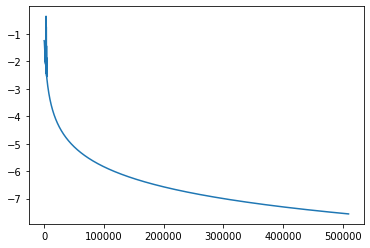

In [106]:
plt.plot(m.nu, np.log10(m.limit))

(100.0, 3500.0)

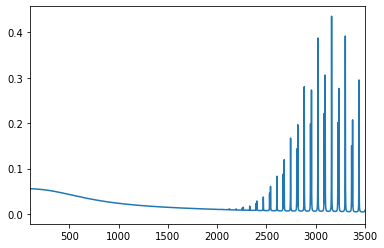

In [107]:
plt.plot(m.nu, (m.limit))
plt.xlim([100, 3500])

1.459632524537433


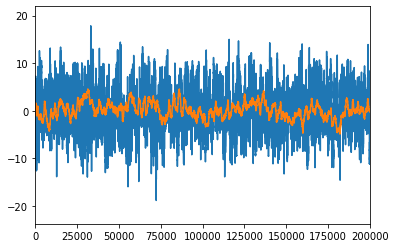

In [108]:
ts = m.timeseries 
plt.plot(m.times, ts)
plt.xlim([0, 200000])
exposure = 1*10 # in cadences ... needs thought.
npts = len(m.timeseries)//exposure
integrated = np.mean(np.reshape(ts[:int(np.floor(npts*exposure))], [exposure, npts]), axis=0)
plt.plot(m.times[::exposure][:len(integrated)], integrated)
print(np.std(integrated))

In [ ]:

for j in range(10):
    pdict = {n: v for n, v in zip(samples.columns, samples.loc[j])}
    exp_list=['dnu', 'numax', 'teff', 'd02', 'alpha_p', 'env_height', 'env_width', 'mode_width', 
              'H1_nu', 'H_power', 'H2_nu', 'd01']
    for key in exp_list:
        pdict[key] = 10**pdict[key]
    limit = m(pdict)
    ts = m.timeseries

    ints = 10**np.linspace(0.2, 3, 50)
    std_dev = np.zeros(len(ints))
    for idx, i in enumerate(ints):
        limit = m(pdict)
        ts = m.timeseries
        exposure = int(np.floor(i)) # in cadences ... needs thought.
        npts = len(m.timeseries)//exposure
        integrated = np.mean(np.reshape(ts[:int(np.floor(npts*exposure))], [exposure, npts]), axis=0)
        std_dev[idx] = np.std(integrated)

    plt.plot(ints, std_dev)

plt.xscale('log')
plt.yscale('log')

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382

Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382 2.94117574 3.92156765 4.90195956
 5.88235147 6.86274338 7.84313529 8.82352721]
Cadence in seconds is [0.         0.98039191 1.96078382